# Feature selection
#### importing libraries and reading in data

In [10]:
import csv
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from graphviz import Source # for drawing decision tree
from IPython.display import SVG # for drawing decision tree
import numpy as np

# motifNames = []
# classes = []
# rawData = []

# with open("data/doubleStrandRaw.csv", "r") as f:
#     motifNames = next(f).split(',')[1:-1] #remove left most column and 'class'
#     for line in f:
#         row = line.strip().split(',')
#         rawData.append(row[1:-1])
#         classes.append(row[-1])

import pandas
raw_data = pandas.read_csv("data/doubleStrandRaw.csv", delimiter=',', true_values=['1.0'], false_values=['0.0', '-1.0'], skipinitialspace=True, warn_bad_lines=True, index_col=0) 
raw_data = raw_data.astype('bool')
print(raw_data)
# print(raw_data.at[raw_data.index[2], "0"])
# print ("number of motif names:", len(motifNames)) 
# print ("number of recorded classes:", len(classes))  
# print ("Data Dimentions:", len(rawData),"rows,", len(rawData[0]), "cols")
# print ("number of classes:", len(classes))
# print ("class of sample 0:", classes[0])


                                                    gimme_15_BioProspector_w10_5  \
sequence                                                                           
AT3G57690|AT3G57690.1|AGP23|3|21384146|21384605                             True   
AT2G18470|AT2G18470.3;AT2G18470.1;AT2G18470.2;A...                         False   
AT4G33970|AT4G33970.1|PEX4|4|16278941|16282048                              True   
AT3G18810|AT3G18810.1|PERK6|3|6480484|6483774                               True   
AT3G01700|AT3G01700.1|AGP11|3|258879|259631                                 True   
AT1G24520|AT1G24520.1|BCP1|1|8688563|8689268                               False   
AT1G23540|AT1G23540.1;AT1G23540.2|PERK12|1|8346...                         False   
AT1G10620|AT1G10620.1|PERK11|1|3509001|3512321                              True   
AT1G49270|AT1G49270.1|PERK7|1|18227122|18230330                             True   
AT4G34440|AT4G34440.2;AT4G34440.1|PERK5|4|16465...                          

#### Transpose data and convert to true / false for simpler code

In [85]:
'''
# convert data to T/F
for row in rawData:
        for cell in rawData[row]:
            if(rawData[row][cell] == '0.0'):
                rawData[row][cell] = False
            elif(rawData[row][cell] == '1.0'):
                rawData[row][cell] = True
                
# # convert data to T/F
for cell in range(len(classes)):
    if(classes[cell] == '0.0'):
        classes[cell] = False
    elif(classes[cell] == '1.0'):
        classes[cell] = True
    
# transpose data
tData = [list(i) for i in zip(*rawData)]
print ("Transposed Dimentions:", len(tData),"rows,", len(tData[0]), "cols")
print ("classes of sample 0:", classes[0])
'''

Transposed Dimentions: 3519 rows, 145 cols
classes of sample 0: True


#### Count how many times each motif occurs in the positive and negative classes

In [86]:
posCounts = []
negCounts = []

for row in range(len(tData)):
    posCount = 0
    negCount = 0
    for col in range(len(tData[row])):
        if(tData[row][col] == True):
            if(classes[col] == True):
                posCount += 1 
            elif(classes[col] == False):
                negCount += 1
    posCounts.append(posCount)
    negCounts.append(negCount)
    
print("first:", posCounts[0], "pos,", negCounts[0], "neg")
print("last:", posCounts[-1], "pos,", negCounts[-1], "neg")
print("max pos: ", max(posCounts))
print("max neg: ", max(negCounts))

first: 9 pos, 5 neg
last: 3 pos, 6 neg
max pos:  13
max neg:  126


In [87]:
numMotifs = len(motifNames)
posCoOccur = [0 for x in range(numMotifs*numMotifs)]
negCoOccur = [0 for x in range(numMotifs*numMotifs)]
for primaryMotif in range(len(tData)):
    for col in range(len(tData[primaryMotif])):
        if(tData[primaryMotif][col]):
            for secondaryMotif in range(primaryMotif+1,numMotifs):
                if(tData[secondaryMotif][col]):
                    if(classes[col]):
                        posCoOccur[primaryMotif + secondaryMotif * numMotifs] += 1
                    else:
                        negCoOccur[primaryMotif + secondaryMotif * numMotifs] += 1


### plot co-occurances

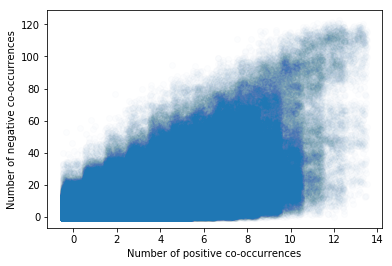

In [88]:
import random
# plt.scatter(list(map(lambda x: x + random.random() -.5, posCounts)), list(map(lambda x: x + random.random() -.5, negCounts)))
# plt.scatter(posCoOccur, negCoOccur, alpha=0.3)
plt.scatter(list(map(lambda x: x + random.random() -.5, posCoOccur)), list(map(lambda x: x + random.random() -.5, negCoOccur)), alpha=0.01)
plt.xlabel("Number of positive co-occurrences")
plt.ylabel("Number of negative co-occurrences")
plt.show()

#### create plots foreground and background counts

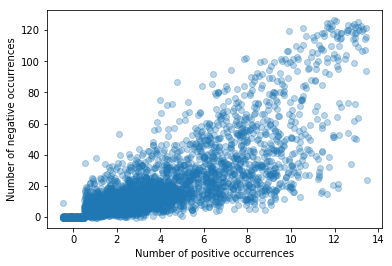

In [89]:
import random
# plt.scatter(list(map(lambda x: x + random.random() -.5, posCounts)), list(map(lambda x: x + random.random() -.5, negCounts)))
# plt.scatter(posCounts, negCounts, alpha=0.3)
plt.scatter(list(map(lambda x: x + random.random() -.5, posCounts)), list(map(lambda x: x + random.random() -.5, negCounts)), alpha=0.3)
plt.xlabel("Number of positive occurrences")
plt.ylabel("Number of negative occurrences")
plt.show()


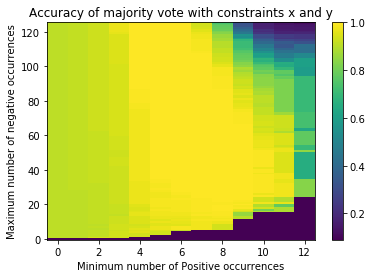

In [90]:
heatData = []
for maxNeg in range(max(negCounts)):
    heatDataRow = []
    for minPos in range(max(posCounts)):
        predictions = [0] * len(classes)
        
        for motif in range(len(posCounts)):
            if(posCounts[motif] > minPos and negCounts[motif] < maxNeg):
                for seq in range(len(classes)):
                    if(tData[motif][seq]):
                        predictions[seq] += 1.0
                    else:
                        predictions[seq] -= 1.0
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        for i in range(len(classes)):
            if(predictions[i] >= 0):
                if(classes[i]):
                    tp += 1.0
                else:
                    fp += 1.0
            else:
                if(classes[i]):
                    fn += 1.0
                else:
                    tn += 1.0
        heatDataRow.append((tp+tn)/(tp+tn+fp+fn))
    heatData.append(heatDataRow)
        
        
    
#         print("Sensitivity:",tp/(tp+fn))
#         print("Specificity:",tn/(tn+fp))
#         print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))

# import matplotlib as mpl
# import numpy as np

img = plt.imshow(np.array(heatData),interpolation='nearest')

plt.colorbar() # make a color bar
plt.axis('auto')
plt.gca().invert_yaxis()
plt.title("Accuracy of majority vote with constraints x and y")
plt.xlabel("Minimum number of Positive occurrences")
plt.ylabel("Maximum number of negative occurrences")
plt.show()

#### create lasso scores

In [91]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=.001)
clf.fit(rawData, classes)
lassoScores = clf.coef_
print(len(lassoScores))

3519


#### split data by if it has a positive and if it has a negative occurance

In [92]:
never = []
neverMotifNames = []
mixed = []
mixedMotifNames = []
right = []
rightMotifNames = []
bottom = []
bottomMotifNames = []
ratio = []
ratioMotifNames = []
lasso = []
lassoMotifNames = []
welchList = []
welchListMotifNames = []
for row in range(len(posCounts)):
    if negCounts[row] == 0 and posCounts[row] == 0:
        never.append(tData[row])
        neverMotifNames.append(motifNames[row])
    else:
        if posCounts[row] >= max(posCounts) - 1:
            right.append(tData[row])
            rightMotifNames.append(motifNames[row])
        if negCounts[row] < 3:
            bottom.append(tData[row])
            bottomMotifNames.append(motifNames[row])
        if posCounts[row] > 0 and negCounts[row] > 0:
            mixed.append(tData[row])
            mixedMotifNames.append(motifNames[row])
        if (posCounts[row] / max(posCounts)) / (1+negCounts[row]/max(negCounts)) > .5:
            ratio.append(tData[row])
            ratioMotifNames.append(motifNames[row])
        if lassoScores[row] > 0:
            lasso.append(tData[row])
            lassoMotifNames.append(motifNames[row]) 
        if posCounts[row] >= 9 and negCounts[row] <= 20:
            welchList.append(tData[row])
            welchListMotifNames.append(motifNames[row]) 
            

In [93]:


# calculate and list metrics for all motifs with foreground >= 9 & background <= 20
print('motif name|true positives|false positives|true negatives|false negatives|accuracy|Sensitivity|Specificity|True Positive + False Negative')

for motif in range(len(welchList)):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(len(welchList[motif])):
        if(welchList[motif][i]):
            if(classes[i]):
                tp += 1
            else:
                fp += 1
        else:
            if(classes[i]):
                fn += 1
            else:
                tn += 1
    if(tn+fp == 0):
        print(welchListMotifNames[motif],"|", tp,"|", fp,"|", tn,"|", fn,"|",(tp+tn)/(tp+tn+fp+fn),"|",tp/(tp+fn),"|", "NA","|", tp+fn)
    else:
        print(welchListMotifNames[motif],"|", tp,"|", fp,"|", tn,"|", fn,"|",(tp+tn)/(tp+tn+fp+fn),"|",tp/(tp+fn),"|",tn/(tn+fp),"|", tp+fn)


motif name|true positives|false positives|true negatives|false negatives|accuracy|Sensitivity|Specificity|True Positive + False Negative
gimme_15_BioProspector_w10_5 | 9 | 5 | 127 | 4 | 0.9379310344827586 | 0.6923076923076923 | 0.9621212121212122 | 13
gimme_143_MEME_4_w12 | 11 | 16 | 116 | 2 | 0.8758620689655172 | 0.8461538461538461 | 0.8787878787878788 | 13
gimme_104_Improbizer_GTGCAACGGAGAGT | 12 | 18 | 114 | 1 | 0.8689655172413793 | 0.9230769230769231 | 0.8636363636363636 | 13
gimme_13_BioProspector_w10_3 | 11 | 17 | 115 | 2 | 0.8689655172413793 | 0.8461538461538461 | 0.8712121212121212 | 13
gimme_106_Improbizer_AACCATCGTT | 9 | 15 | 117 | 4 | 0.8689655172413793 | 0.6923076923076923 | 0.8863636363636364 | 13
gimme_30_AMD_Motif5 | 10 | 19 | 113 | 3 | 0.8482758620689655 | 0.7692307692307693 | 0.8560606060606061 | 13
gimme_132_MEME_3_w10 | 12 | 15 | 117 | 1 | 0.8896551724137931 | 0.9230769230769231 | 0.8863636363636364 | 13
gimme_102_Improbizer_GCGTTATACCCGAGGATCAG | 12 | 20 | 112 | 1 

#### create a decision tree and train it on mixedData

#### display the tree we've genorated

#### count true positves, flase negatives etc. and calculate metrics

In [40]:
tp = 0
fp = 0
tn = 0
fn = 0
for i in range(len(selectedPredictions)):
    if(selectedPredictions[i]):
        if(y_test[i]):
            tp += 1
        else:
            fp += 1
    else:
        if(y_test[i]):
            fn += 1
        else:
            tn += 1
print("true positives:", tp)
print("false positives:", fp)
print("true negatives:", tn)
print("false negatives:", fn)
if fp > 0:
    print("true positive to false positive ratio:",tp/fp)
if fn > 0:
    print("true negative to false negative ratio:",tn/fn)
print("Sensitivity:",tp/(tp+fn))
print("Specificity:",tn/(tn+fp))
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))

NameError: name 'selectedPredictions' is not defined

## Code for another day (we aren't using now but might later) 

In [9]:
selected = lasso
selectedNames = lassoMotifNames

selectedTree = tree.DecisionTreeClassifier()
selectedData = [list(i) for i in zip(*selected)]
x_train, x_test, y_train, y_test = train_test_split(selectedData, classes, test_size=0.33)
selectedTree = selectedTree.fit(x_train, y_train)

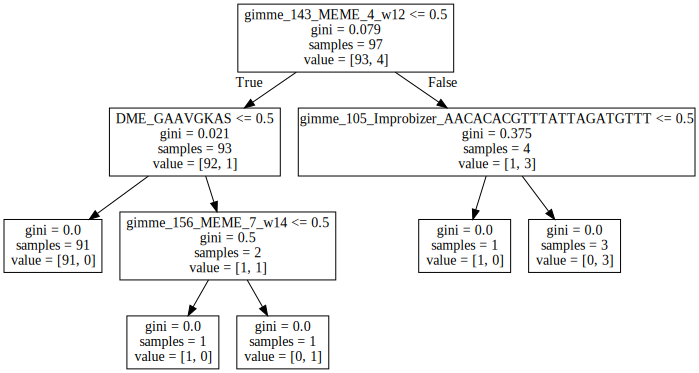

In [10]:
selectedPredictions = selectedTree.predict(x_test)
graph = Source( tree.export_graphviz(selectedTree, out_file=None, feature_names=selectedNames))
SVG(graph.pipe(format='svg'))

In [11]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=.001)
clf.fit(rawData, classes)
print(clf.coef_)

[ 0.          0.01633253  0.06283913 ...,  0.          0.          0.        ]
